In [1]:
import pandas as pd
import math
import numpy as np
import criteopy
from IPython.display import display, HTML
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

oAXD = criteopy.AXDBTools()

Generate the dataset

Matched Sales

In [ ]:
query_matched_sales = """
SELECT
    collection_timestamp AS timestamp
    , environment
    , os
    , device
    , fmt.campaign_id
    , to_hex(md5(to_utf8(cast(user_id_fast as varchar)))) AS user_id
    , context_id
    , CASE
        WHEN transaction_id = '' THEN '' 
        ELSE to_hex(md5(to_utf8(cast(transaction_id as varchar)))) END AS transaction_id
    , order_value_local AS order_value
FROM
    bi_raw_logs.fact_matched_transactions fmt
INNER JOIN 
    bi_core.dim_campaign dca 
ON
    fmt.campaign_id = dca.campaign_id
    AND dca.client_id = 22
WHERE
    day_part >= '2019-10-01'
    AND day_part <= '2020-01-30'
    AND attribution_type = 'pc'
    AND matching_type = 0
UNION ALL
SELECT
    (collection_timestamp + 10) AS timestamp
    , environment
    , os
    , device
    , fmt.campaign_id
    , to_hex(md5(to_utf8(cast(user_id_fast as varchar)))) AS user_id
    , context_id
    , CASE
        WHEN transaction_id = '' THEN '' 
        ELSE to_hex(md5(to_utf8(cast(transaction_id as varchar)))) END AS transaction_id
    , order_value_local AS order_value
FROM
    bi_raw_logs.fact_matched_transactions fmt
INNER JOIN 
    bi_core.dim_campaign dca 
ON
    fmt.campaign_id = dca.campaign_id
    AND dca.client_id = 22
WHERE
    day_part >= '2019-11-08'
    AND day_part <= '2020-01-30'
    AND attribution_type = 'pc'
    AND matching_type = 0
    AND environment = 'app'
    AND os = 'Android'
ORDER BY 1
"""
output_matched_sales = oAXD.run_presto_query(query_matched_sales)
file_matched_sales = output_matched_sales.rename(columns={"timestamp": "Timestamp", "environment": "Environment", "os":"Os", "device":"Device"
                                          , "campaign_id":"Campaign ID", "user_id":"User ID", "context_id":"Context ID"
                                         , "transaction_id":"Transaction ID", "order_value":"Order Value"})
file_matched_sales.to_csv("matched_sales.tsv", sep ='\t', index = 0) 

Campaigns Delivery

In [ ]:
query_campaigns_delivery = """
SELECT
    fcd.day
    , fcd.environment
    , fcd.os
    , fcd.campaign_id
    , case
        when campaign_revenue_type = 1 then 'Display Optimization'
        when campaign_revenue_type = 2 then 'Click Optimization'
        when campaign_revenue_type in (9,10,11) then 'Conversion Optimization'
        when campaign_revenue_type in (12, 14, 15) then 'Revenue Optimization'
        when campaign_revenue_type in (16, 17) then 'Value Optimization (VO)'
        when campaign_revenue_type IN (19,21) then 'Visit Optimization'
        when campaign_revenue_type = 23 then 'Video Awareness Optimization (VAWARE-CPM)'
        when campaign_revenue_type in (24, 25, 28) then 'Install Optimization'
        when campaign_revenue_type = 27 then 'Offline Conversion Optimization (CPC_OCR)'
        when campaign_revenue_type = 29 then 'Budget Conversion Optimization'
        when campaign_revenue_type = 30 then 'Budget Visit Optimization'
        end AS campaign_optimization
    , dca.campaign_type_name AS campaign_type
    , dca.campaign_context_setup AS context_id_eligible
    , SUM(displays) AS displays
    , SUM(clicks) AS clicks
    , SUM(revenue_euro) AS criteo_revenue
    , SUM(tac_euro) AS criteo_cost
FROM
    bi_core.fact_campaign_device_stats_daily fcd
INNER JOIN
    bi_core.dim_campaign dca
ON
    fcd.campaign_id = dca.campaign_id
    AND dca.client_id = 22
WHERE
    day_part >= '2019-10-07'
    AND day_part <= '2020-01-30'
GROUP BY
   fcd.day
    , fcd.environment
    , fcd.os
    , fcd.campaign_id
    ,  case
        when campaign_revenue_type = 1 then 'Display Optimization'
        when campaign_revenue_type = 2 then 'Click Optimization'
        when campaign_revenue_type in (9,10,11) then 'Conversion Optimization'
        when campaign_revenue_type in (12, 14, 15) then 'Revenue Optimization'
        when campaign_revenue_type in (16, 17) then 'Value Optimization (VO)'
        when campaign_revenue_type IN (19,21) then 'Visit Optimization'
        when campaign_revenue_type = 23 then 'Video Awareness Optimization (VAWARE-CPM)'
        when campaign_revenue_type in (24, 25, 28) then 'Install Optimization'
        when campaign_revenue_type = 27 then 'Offline Conversion Optimization (CPC_OCR)'
        when campaign_revenue_type = 29 then 'Budget Conversion Optimization'
        when campaign_revenue_type = 30 then 'Budget Visit Optimization'
        end
    , dca.campaign_type_name
    , dca.campaign_context_setup
"""

output_campaigns_delivery = oAXD.run_presto_query(query_campaigns_delivery) 
file_campaigns_delivery = output_campaigns_delivery.rename(columns={"day": "Day", "environment": "Environment", "os":"Os", "device":"Device"
                                          , "campaign_id":"Campaign ID", "campaign_optimization":"Campaign Optimization"
                                          , "campaign_type": "Campaign Type", "context_id_eligible": "Context IDs Eligible"
                                         , "displays": "Number of displays", "clicks": "Number of clicks"
                                          , "criteo_revenue":"Criteo Revenue", "criteo_cost":"Criteo Cost"})
file_campaigns_delivery.to_csv("campaigns_delivery.tsv", sep ='\t', index = 0) 

## Analyze matched_sales.tsv Dataset

In [2]:
## Load the data 

matched_sales_df = pd.read_csv("matched_sales.tsv", sep ='\t')
matched_sales_df = matched_sales_df.rename(columns={"Timestamp": "timestamp", "Environment": "environment", "Os":"os", "Device":"device"
                                          , "Campaign ID":"campaign_id", "User ID":"user_id", "Context ID":"context_id"
                                         , "Transaction ID":"transaction_id", "Order Value":"order_value"})

print('The Matched Sales dataset contains '+str(matched_sales_df.shape[0])+' rows and '+str(matched_sales_df.shape[1]) + ' columns')
matched_sales_df.head()

The Matched Sales dataset contains 356495 rows and 9 columns


,timestamp,environment,os,device,campaign_id,user_id,context_id,transaction_id,order_value
0,1569889040,web,Windows,Desktop,113450,2EEEE2185BB347E07653128DDD7946B4,6,687260E81F123BF7B22EB42E2CC740D9,32.08
1,1569890180,web,Android,Smartphone,137914,18F4B9C704A39843FE4354E1E2091942,8,4CA9C121F6F94CD135F4A6F4934D4843,149.92
2,1569890704,web,Windows,Desktop,137914,513CD8C04005C7ED66F34CD98C63C455,9,F44BB650A3149704B9F86EF8796E6604,125.10
3,1569892066,web,Android,Smartphone,137914,1620E50E507DDF33489D80D7423111DF,7,5E022540529ECBCB947C04D969260287,95.95
4,1569892673,web,Windows,Desktop,137914,85AC7958028EFF2231B4962D3611D2D3,6,8428EF0717350A6C843B91957A30464B,83.54


### Clean the dataset

In [3]:
matched_sales_df.order_value.describe()

count    356495.000000
mean         75.700024
std         139.694391
min           0.000000
25%          28.580000
50%          47.620000
75%          84.250000
max       51658.000000
Name: order_value, dtype: float64

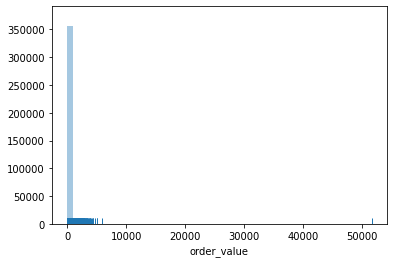

In [4]:
## Searching for transactions with abnormally high order value
sns.distplot(matched_sales_df.order_value, kde=False, rug=True)

In [6]:
## Searching for transactions with order value = 0
matched_sales_df['zero_ov'] = (matched_sales_df.order_value == 0)
display(matched_sales_df.head())
matched_sales_df.zero_ov.describe()

,timestamp,environment,os,device,campaign_id,user_id,context_id,transaction_id,order_value,zero_ov
0,1569889040,web,Windows,Desktop,113450,2EEEE2185BB347E07653128DDD7946B4,6,687260E81F123BF7B22EB42E2CC740D9,32.08,False
1,1569890180,web,Android,Smartphone,137914,18F4B9C704A39843FE4354E1E2091942,8,4CA9C121F6F94CD135F4A6F4934D4843,149.92,False
2,1569890704,web,Windows,Desktop,137914,513CD8C04005C7ED66F34CD98C63C455,9,F44BB650A3149704B9F86EF8796E6604,125.10,False
3,1569892066,web,Android,Smartphone,137914,1620E50E507DDF33489D80D7423111DF,7,5E022540529ECBCB947C04D969260287,95.95,False
4,1569892673,web,Windows,Desktop,137914,85AC7958028EFF2231B4962D3611D2D3,6,8428EF0717350A6C843B91957A30464B,83.54,False


count     356495
unique         2
top        False
freq      354827
Name: zero_ov, dtype: object

In [7]:
## Cleaning up the data wrt order_value
matched_sales_df_clean = matched_sales_df[(matched_sales_df.zero_ov == False) & (matched_sales_df.order_value <= 40000)]

print('The Matched Sales dataset cleaned up wrt order_value contains '+str(matched_sales_df_clean.shape[0])+' rows')


The Matched Sales dataset cleaned up wrt order_value contains 354826 rows


In [8]:
## Identifying empty or null transaction_ids and replace with an artifical transaction_id
matched_sales_df_clean['missing_transaction_id'] = (matched_sales_df_clean.transaction_id == '') | (matched_sales_df_clean.transaction_id.isnull())
matched_sales_df_clean['clean_transaction_id'] = np.where(matched_sales_df_clean.missing_transaction_id == True
                                                          , matched_sales_df_clean.timestamp.map(str)+matched_sales_df_clean.user_id
                                                        , matched_sales_df_clean.transaction_id)
## Check it looks ok
matched_sales_df_clean[(matched_sales_df_clean.missing_transaction_id == True)]

,timestamp,environment,os,device,campaign_id,user_id,context_id,transaction_id,order_value,zero_ov,missing_transaction_id,clean_transaction_id
20982,1570629085,web,Mac OS,Desktop,137914,564B91EF9662EC740C7C69BB5222AD34,6,NaN,98.38,False,True,1570629085564B91EF9662EC740C7C69BB5222AD34
50186,1571759978,web,Android,Smartphone,137914,4E7C212B3126AD1B48406BC4F9D39418,8,NaN,29.25,False,True,15717599784E7C212B3126AD1B48406BC4F9D39418
50190,1571760071,web,Android,Smartphone,137914,4E7C212B3126AD1B48406BC4F9D39418,8,NaN,29.25,False,True,15717600714E7C212B3126AD1B48406BC4F9D39418
55555,1571986973,web,Android,Tablet,194905,457820D0EF2B655422D6E9314564FAD0,8,NaN,52.98,False,True,1571986973457820D0EF2B655422D6E9314564FAD0
62949,1572247845,web,Android,Smartphone,113890,DEA1AD6ADBD981DDB2CD5A9AC5089785,6,NaN,91.66,False,True,1572247845DEA1AD6ADBD981DDB2CD5A9AC5089785
70750,1572506825,web,Android,Tablet,194905,457820D0EF2B655422D6E9314564FAD0,8,NaN,57.15,False,True,1572506825457820D0EF2B655422D6E9314564FAD0
96482,1573370005,web,Android,Tablet,137914,59B680B495ECCAA348B1AE3219CB0990,8,NaN,54.43,False,True,157337000559B680B495ECCAA348B1AE3219CB0990
123096,1574105483,web,Android,Tablet,137914,59B680B495ECCAA348B1AE3219CB0990,8,NaN,50.85,False,True,157410548359B680B495ECCAA348B1AE3219CB0990
133899,1574360007,web,Android,Tablet,137914,B9EB78040B17F76A9A66BED92576C1FD,6,NaN,96.87,False,True,1574360007B9EB78040B17F76A9A66BED92576C1FD
135288,1574410024,web,Android,Tablet,137914,B9EB78040B17F76A9A66BED92576C1FD,6,NaN,96.87,False,True,1574410024B9EB78040B17F76A9A66BED92576C1FD


In [9]:
## Identifying duplicated transaction_ids. Duplicates are rows that have the same transaction_id, user_id and order_value

matched_sales_df_clean['duplicates'] = matched_sales_df_clean.sort_values(by=['timestamp']).duplicated(subset=['clean_transaction_id','user_id','order_value'])
print(matched_sales_df_clean.duplicates.describe())
## Cleaning up the data wrt transactions
matched_sales_df_clean = matched_sales_df_clean[(matched_sales_df_clean.duplicates == False)]

print('\nThe Matched Sales dataset cleaned up wrt order_value AND duplicate transaction_id contains '+str(matched_sales_df_clean.shape[0])+' rows')

count     354826
unique         2
top        False
freq      354409
Name: duplicates, dtype: object

The Matched Sales dataset cleaned up wrt order_value AND duplicate transaction_id contains 354409 rows


### Timezone Estimation

In [10]:
matched_sales_df_clean['date_time'] = pd.to_datetime(matched_sales_df_clean['timestamp'],unit='s')
matched_sales_df_clean['day'] = matched_sales_df_clean['date_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
matched_sales_df_clean['hour'] = matched_sales_df_clean['date_time'].apply(lambda x: x.hour)
matched_sales_df_clean['day_name'] = matched_sales_df_clean['date_time'].apply(lambda y: y.dayofweek)
matched_sales_df_clean['week'] = matched_sales_df_clean['date_time'].apply(lambda y: y.week)
matched_sales_df_clean['year'] = matched_sales_df_clean['date_time'].apply(lambda y: y.year)

matched_sales_df_clean.head()

,timestamp,environment,os,device,campaign_id,user_id,context_id,transaction_id,order_value,zero_ov,missing_transaction_id,clean_transaction_id,duplicates,date_time,day,hour,day_name,week,year
0,1569889040,web,Windows,Desktop,113450,2EEEE2185BB347E07653128DDD7946B4,6,687260E81F123BF7B22EB42E2CC740D9,32.08,False,False,687260E81F123BF7B22EB42E2CC740D9,False,2019-10-01 00:17:20,2019-10-01,0,1,40,2019
1,1569890180,web,Android,Smartphone,137914,18F4B9C704A39843FE4354E1E2091942,8,4CA9C121F6F94CD135F4A6F4934D4843,149.92,False,False,4CA9C121F6F94CD135F4A6F4934D4843,False,2019-10-01 00:36:20,2019-10-01,0,1,40,2019
2,1569890704,web,Windows,Desktop,137914,513CD8C04005C7ED66F34CD98C63C455,9,F44BB650A3149704B9F86EF8796E6604,125.10,False,False,F44BB650A3149704B9F86EF8796E6604,False,2019-10-01 00:45:04,2019-10-01,0,1,40,2019
3,1569892066,web,Android,Smartphone,137914,1620E50E507DDF33489D80D7423111DF,7,5E022540529ECBCB947C04D969260287,95.95,False,False,5E022540529ECBCB947C04D969260287,False,2019-10-01 01:07:46,2019-10-01,1,1,40,2019
4,1569892673,web,Windows,Desktop,137914,85AC7958028EFF2231B4962D3611D2D3,6,8428EF0717350A6C843B91957A30464B,83.54,False,False,8428EF0717350A6C843B91957A30464B,False,2019-10-01 01:17:53,2019-10-01,1,1,40,2019


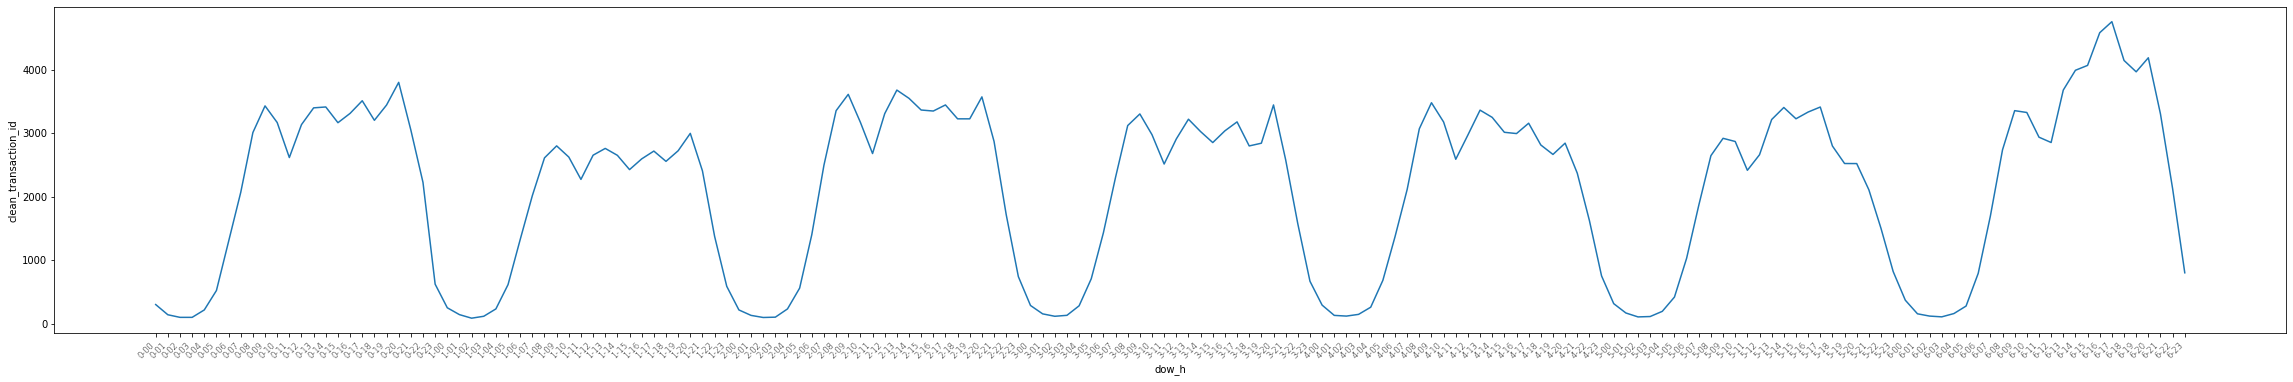

In [11]:
plt.figure(figsize=(40, 6)) 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')

sales_by_hour = matched_sales_df_clean[['clean_transaction_id','hour','day_name']].groupby(['day_name','hour']).count() 
sales_by_hour = sales_by_hour.reset_index()

sales_by_hour['hour_str'] = sales_by_hour.hour.map(str)
sales_by_hour['hour_str'] = sales_by_hour['hour_str'].str.zfill(2)

sales_by_hour['dow_h'] = sales_by_hour.day_name.map(str)+'-'+sales_by_hour.hour_str
sns.lineplot(x = 'dow_h',y = 'clean_transaction_id', data=sales_by_hour)


### Evolution of the Criteo attributed revenue 

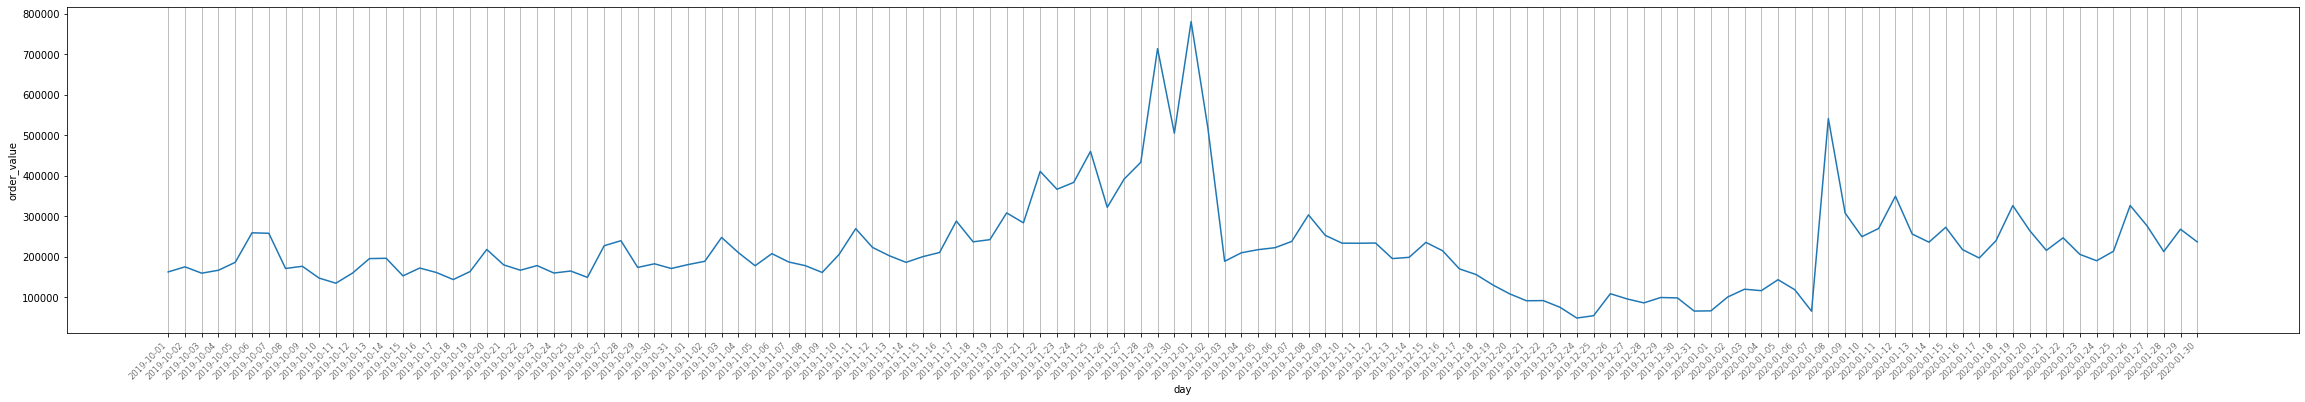

In [12]:
plt.figure(figsize=(40, 6)) 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.gca().xaxis.grid(True)


revenue_by_day = matched_sales_df_clean[['day','order_value','clean_transaction_id']].groupby(['day']).sum() 
revenue_by_day = revenue_by_day.reset_index()
sns.lineplot(x = 'day',y = 'order_value', data=revenue_by_day)

### Evolution of the AOV by Os

In [13]:
matched_sales_df_clean.head()

,timestamp,environment,os,device,campaign_id,user_id,context_id,transaction_id,order_value,zero_ov,missing_transaction_id,clean_transaction_id,duplicates,date_time,day,hour,day_name,week,year
0,1569889040,web,Windows,Desktop,113450,2EEEE2185BB347E07653128DDD7946B4,6,687260E81F123BF7B22EB42E2CC740D9,32.08,False,False,687260E81F123BF7B22EB42E2CC740D9,False,2019-10-01 00:17:20,2019-10-01,0,1,40,2019
1,1569890180,web,Android,Smartphone,137914,18F4B9C704A39843FE4354E1E2091942,8,4CA9C121F6F94CD135F4A6F4934D4843,149.92,False,False,4CA9C121F6F94CD135F4A6F4934D4843,False,2019-10-01 00:36:20,2019-10-01,0,1,40,2019
2,1569890704,web,Windows,Desktop,137914,513CD8C04005C7ED66F34CD98C63C455,9,F44BB650A3149704B9F86EF8796E6604,125.10,False,False,F44BB650A3149704B9F86EF8796E6604,False,2019-10-01 00:45:04,2019-10-01,0,1,40,2019
3,1569892066,web,Android,Smartphone,137914,1620E50E507DDF33489D80D7423111DF,7,5E022540529ECBCB947C04D969260287,95.95,False,False,5E022540529ECBCB947C04D969260287,False,2019-10-01 01:07:46,2019-10-01,1,1,40,2019
4,1569892673,web,Windows,Desktop,137914,85AC7958028EFF2231B4962D3611D2D3,6,8428EF0717350A6C843B91957A30464B,83.54,False,False,8428EF0717350A6C843B91957A30464B,False,2019-10-01 01:17:53,2019-10-01,1,1,40,2019


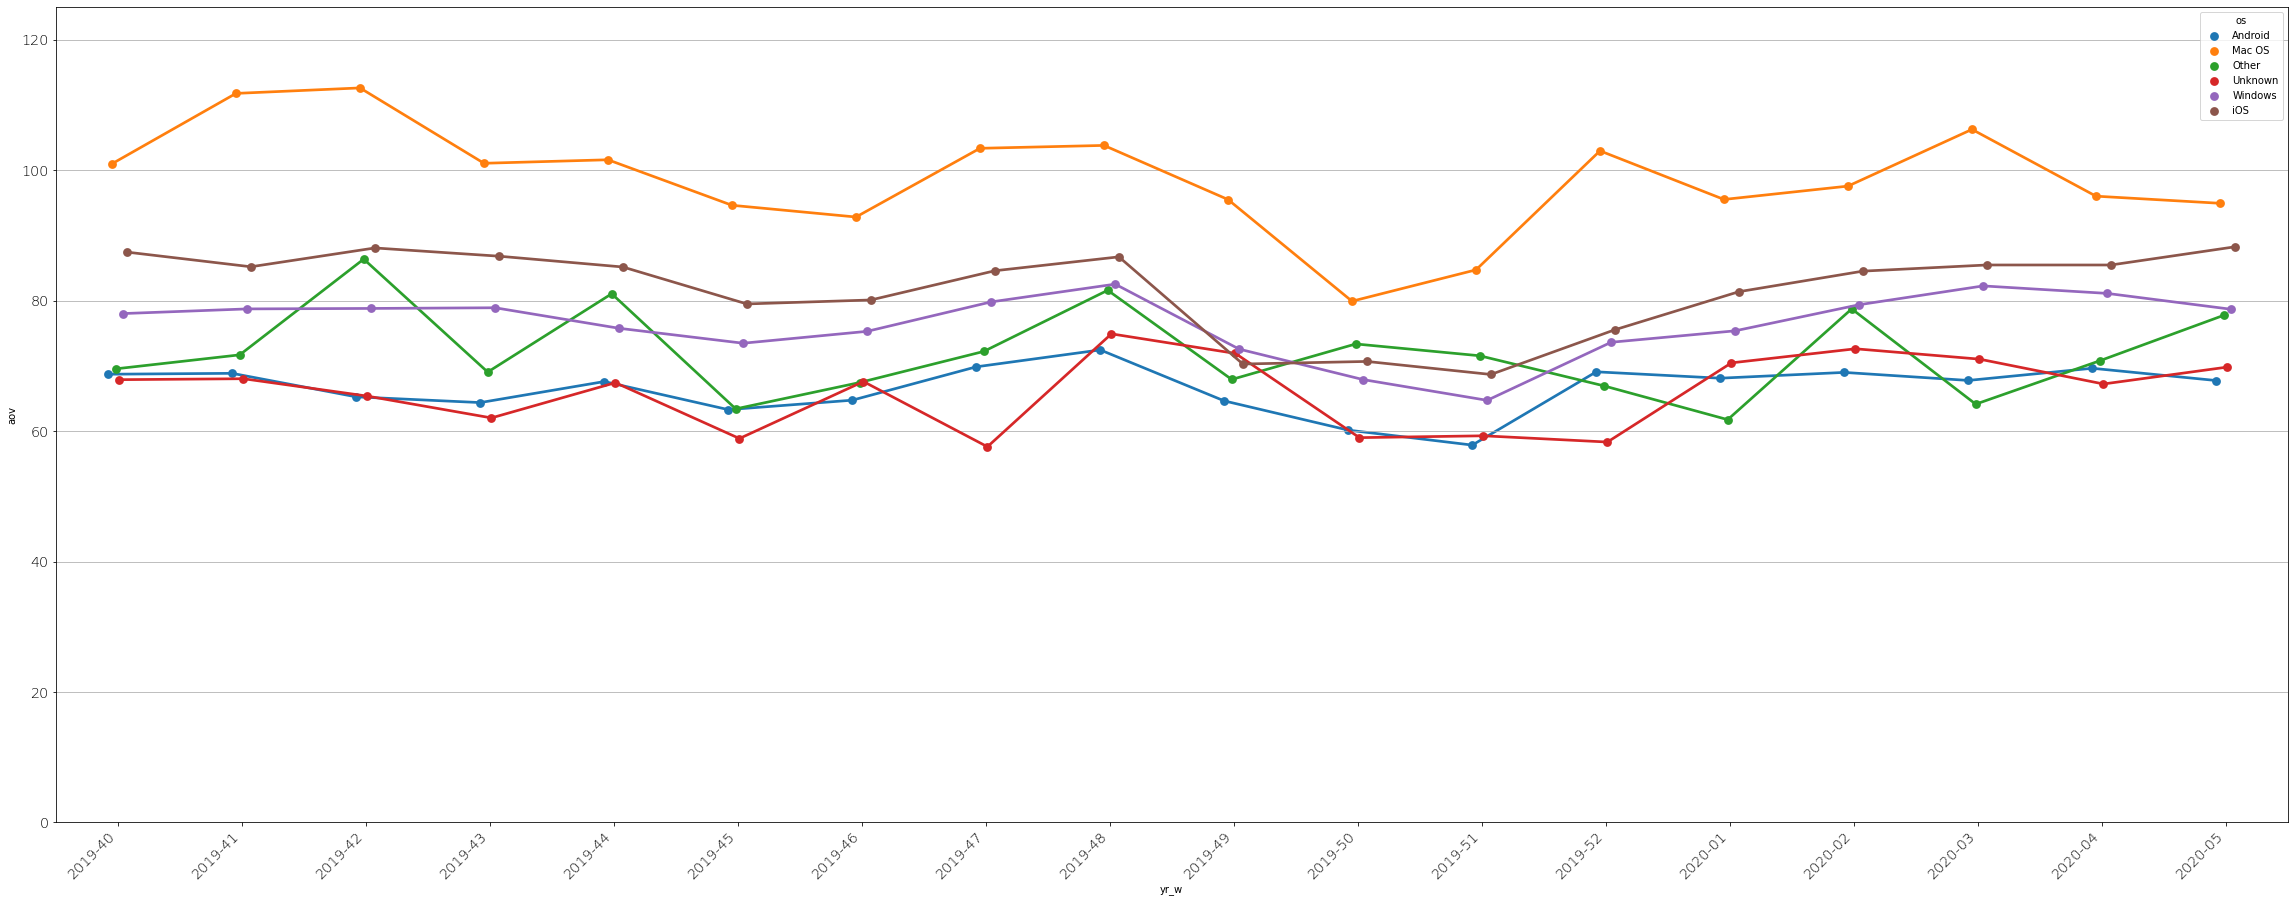

In [14]:
plt.figure(figsize=(40, 15)) 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.gca().yaxis.grid(True)
plt.ylim(0, 125)


stats_by_weekxenv = matched_sales_df_clean.groupby(['week','os']).agg({'order_value':'sum', 
                         'clean_transaction_id':'count', 'year':'max'})
stats_by_weekxenv = stats_by_weekxenv.reset_index()
stats_by_weekxenv = stats_by_weekxenv.sort_values(by=['year','week'])
stats_by_weekxenv['aov'] = stats_by_weekxenv.order_value/stats_by_weekxenv.clean_transaction_id


stats_by_weekxenv['week_str'] = stats_by_weekxenv.week.map(str)
stats_by_weekxenv['week_str'] = stats_by_weekxenv['week_str'].str.zfill(2)

stats_by_weekxenv['yr_w'] = stats_by_weekxenv.year.map(str)+'-'+stats_by_weekxenv.week_str

stats_by_weekxenv.head(10)

sns.pointplot(x = 'yr_w' ,y = 'aov', data=stats_by_weekxenv, hue='os', dodge = True)


## Analyze campaigns_delivery.tsv

In [ ]:
## Load the data 

camp_del_df = pd.read_csv("campaigns_delivery.tsv", sep ='\t')
camp_del_df = camp_del_df.rename(columns={"Day": "day", "Environment": "environment", "Os":"os", "Campaign ID":"campaign_id"
                                          , "Campaign Optimization":"campaign_optimization", "Campaign Type":"campaign_type"
                                          , "Context IDs Eligible":"context_id_eligible", "Number of displays":"displays"
                                          , "Number of clicks":"clicks", "Criteo Revenue":"revenue", "Criteo Cost":"cost"})


print('The campaign delivery dataset contains '+str(camp_del_df.shape[0])+' rows and '+str(camp_del_df.shape[1]) + ' columns')
print('\nThe campaign delivery dataset goes from '+str(camp_del_df.day.min())+' to '+str(camp_del_df.day.max()))


### Compute the average margin

In [ ]:
## Average Margin
avg_margin = (camp_del_df.revenue.sum() - camp_del_df.cost.sum())/camp_del_df.revenue.sum()
print("Criteo's average margin on the dataset is " + str(round(avg_margin *100)) +"%")

In [ ]:
#New fields for analysis
camp_del_df['day_fmt'] = camp_del_df.day.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
camp_del_df['week'] = camp_del_df.day_fmt.dt.week
camp_del_df['year'] = camp_del_df.day_fmt.dt.year

### Evolution of margin over time

In [ ]:
#Margin fluctuation day over day
plt.figure(figsize=(40, 6)) 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.gca().yaxis.grid(True)

margin_day_df = camp_del_df.groupby(['day']).agg({'revenue':'sum', 'cost':'sum'})
margin_day_df = margin_day_df.reset_index()
margin_day_df['margin'] =(margin_day_df.revenue-margin_day_df.cost)/(margin_day_df.revenue)

sns.pointplot(x = 'day' ,y = 'margin', data=margin_day_df, dodge = True)

In [ ]:
#Margin fluctuation week over week
plt.figure(figsize=(40, 6)) 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.gca().yaxis.grid(True)

margin_week_df = camp_del_df.groupby(['week']).agg({'revenue':'sum', 'cost':'sum', 'year':'max'})
margin_week_df = margin_week_df.reset_index()
margin_week_df = margin_week_df.sort_values(by=['year','week'])
margin_week_df['margin'] =(margin_week_df.revenue-margin_week_df.cost)/(margin_week_df.revenue)

margin_week_df['week_str'] = margin_week_df.week.map(str)
margin_week_df['week_str'] = margin_week_df['week_str'].str.zfill(2)
margin_week_df['yr_w'] = margin_week_df.year.map(str)+'-'+margin_week_df.week_str
margin_week_df.head(100)

sns.pointplot(x = 'yr_w' ,y = 'margin', data = margin_week_df, dodge = True)

### Evolution of margin over time and by product

In [ ]:
#Margin fluctuation by product week over week
plt.figure(figsize=(40, 6)) 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.gca().yaxis.grid(True)

margin_prod_df = camp_del_df.groupby(['week','campaign_type']).agg({'revenue':'sum', 'cost':'sum', 'year':'max'})
margin_prod_df = margin_prod_df.reset_index()
margin_prod_df = margin_prod_df.sort_values(by=['year','week'])
margin_prod_df['margin'] =(margin_prod_df.revenue-margin_prod_df.cost)/(margin_prod_df.revenue)

margin_prod_df['week_str'] = margin_prod_df.week.map(str)
margin_prod_df['week_str'] = margin_prod_df['week_str'].str.zfill(2)
margin_prod_df['yr_w'] = margin_prod_df.year.map(str)+'-'+margin_prod_df.week_str
margin_prod_df.head(100)

margin_prod_df.to_csv("margin_prod_df.csv", sep = '\t')

sns.pointplot(x = 'yr_w' ,y = 'margin', data=margin_prod_df, hue = 'campaign_type', dodge = True)

## Join the 2 datasets

In [ ]:
## Aggregate matched_sales_df_clean and remove first days of October

matched_sales_df_clean = matched_sales_df_clean[['day','environment', 'os', 'campaign_id', 'clean_transaction_id', 'order_value']]
matched_sales_df_agg = matched_sales_df_clean.groupby(['day','environment','os','campaign_id']).agg({'order_value':'sum', 
                         'clean_transaction_id':'count'})
matched_sales_df_agg = matched_sales_df_agg.reset_index()
matched_sales_df_agg = matched_sales_df_agg.rename(columns={"order_value": "adv_revenue", "clean_transaction_id": "sales"})
print('The matched sales dataset goes from '+str(matched_sales_df_agg.day.min())+' to '+str(matched_sales_df_agg.day.max()))
matched_sales_df_agg = matched_sales_df_agg[(matched_sales_df_agg.day >= '2019-10-07')]
print('Now the matched sales dataset goes from '+str(matched_sales_df_agg.day.min())+' to '+str(matched_sales_df_agg.day.max()))

In [ ]:
## Merge
camp_perf_df = pd.merge(camp_del_df,matched_sales_df_agg, on=['day', 'environment','os','campaign_id'], how='outer')

## Analyze Criteo Campaigns Performance from the advertiser’s perspective

### Performance and Volume of Criteo Campaigns

In [ ]:
plt.figure(figsize=(40, 6)) 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.gca().yaxis.grid(True)



adv_perf_campaign_df = camp_perf_df.groupby(['campaign_id']).agg({'adv_revenue':'sum', 'revenue':'sum'})
adv_perf_campaign_df = adv_perf_campaign_df.reset_index()
adv_perf_campaign_df['cos'] = adv_perf_campaign_df.revenue/adv_perf_campaign_df.adv_revenue

adv_perf_campaign_df = adv_perf_campaign_df.astype({'campaign_id': 'str'})

sns.scatterplot(x="adv_revenue", y="cos", data=adv_perf_campaign_df, hue="campaign_id")

In [ ]:
adv_perf_campaign_df.sort_values(by=['cos'], ascending = True).head(10)

### Performance and Volume of Criteo Campaign Types

In [ ]:
plt.figure(figsize=(40, 6)) 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.gca().yaxis.grid(True)

adv_perf_camp_type_df = camp_perf_df.groupby(['campaign_type']).agg({'adv_revenue':'sum', 'revenue':'sum'})
adv_perf_camp_type_df = adv_perf_camp_type_df.reset_index()
adv_perf_camp_type_df['cos'] = adv_perf_camp_type_df.revenue/adv_perf_camp_type_df.adv_revenue
sns.scatterplot(x="adv_revenue", y="cos", data=adv_perf_camp_type_df,hue="campaign_type")

### Define Performance by Campaign Type

In [ ]:
camp_type_measurement = camp_del_df[['campaign_type','campaign_optimization']]
camp_type_measurement = camp_type_measurement.drop_duplicates()
camp_type_measurement